In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
chunksize = 100_000
train_data = pd.read_json('../data/raw/train.jsonl', lines = True, chunksize = chunksize)
test_data = pd.read_json('../data/raw/test.jsonl', lines = True, chunksize = chunksize)
sample_submission = pd.read_csv('../data/raw/sample_submission.csv', chunksize=chunksize)

In [4]:
train = pd.DataFrame()
for i, chunk in enumerate(train_data):
    event_dict = {
        'session': [],
        'aid':     [],
        'ts':      [],
        'type':    []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                                chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])
train = train.reset_index(drop=True)

In [5]:
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [6]:
test = pd.DataFrame()
for i, chunk in enumerate(test_data):
    event_dict = {
        'session': [],
        'aid':     [],
        'ts':      [],
        'type':    []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                                chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    test = pd.concat([test, chunk_session])
test = test.reset_index(drop=True)

In [7]:
display(test)

,session,aid,ts,type
0,12899779,59625,1661724000278,clicks
1,12899780,1142000,1661724000378,clicks
2,12899780,582732,1661724058352,clicks
3,12899780,973453,1661724109199,clicks
4,12899780,736515,1661724136868,clicks
...,...,...,...,...
928110,13099776,1159407,1661844072138,clicks
928111,13099776,546448,1661844142618,clicks
928112,13099777,468584,1661795832787,clicks
928113,13099778,926609,1661795832939,clicks


# columns
    session -> the unique session id
    aid -> the article id (product code) of the associated event
    ts -> the Unix timestamp of the event
    type -> the event type, i.e., whether a product was clicked, added to the user's cart, or ordered during the session

# Making Dataset

In [8]:
train.rename(index=str, columns={'session': 'customer_id',
                                'aid' : 'product_code',
                                'ts' : 'time_stamp',
                                'type' : 'event_type'}, inplace=True)
display(train)

,customer_id,product_code,time_stamp,event_type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [9]:
#  change ts to datetime
train['time_stamp_all'] = pd.to_datetime(train['time_stamp'], unit='ms')
train

,customer_id,product_code,time_stamp,event_type,time_stamp_all
0,0,1517085,1659304800025,clicks,2022-07-31 22:00:00.025
1,0,1563459,1659304904511,clicks,2022-07-31 22:01:44.511
2,0,1309446,1659367439426,clicks,2022-08-01 15:23:59.426
3,0,16246,1659367719997,clicks,2022-08-01 15:28:39.997
4,0,1781822,1659367871344,clicks,2022-08-01 15:31:11.344
...,...,...,...,...,...
10285556,199999,928064,1659336408967,clicks,2022-08-01 06:46:48.967
10285557,199999,849970,1659336449078,clicks,2022-08-01 06:47:29.078
10285558,199999,1052480,1659336547035,clicks,2022-08-01 06:49:07.035
10285559,199999,487255,1659336561116,clicks,2022-08-01 06:49:21.116


In [10]:
#  add year and month as a column
train.insert(loc=2, column='year_month', value=train.time_stamp_all.map(lambda x: 100*x.year + x.month))

#  break out the year 
train.insert(loc=3, column='year', value=train.time_stamp_all.dt.year)

#  break out the month
train.insert(loc=4, column='month', value=train.time_stamp_all.dt.month)

#  break out the day
train.insert(loc=5, column='day', value=(train.time_stamp_all.dt.dayofweek)+1)

#  break out the hour
train.insert(loc=6, column='hour', value=(train.time_stamp_all.dt.hour)+1)

display(train)


,customer_id,product_code,year_month,year,month,day,hour,time_stamp,event_type,time_stamp_all
0,0,1517085,202207,2022,7,7,23,1659304800025,clicks,2022-07-31 22:00:00.025
1,0,1563459,202207,2022,7,7,23,1659304904511,clicks,2022-07-31 22:01:44.511
2,0,1309446,202208,2022,8,1,16,1659367439426,clicks,2022-08-01 15:23:59.426
3,0,16246,202208,2022,8,1,16,1659367719997,clicks,2022-08-01 15:28:39.997
4,0,1781822,202208,2022,8,1,16,1659367871344,clicks,2022-08-01 15:31:11.344
...,...,...,...,...,...,...,...,...,...,...
10285556,199999,928064,202208,2022,8,1,7,1659336408967,clicks,2022-08-01 06:46:48.967
10285557,199999,849970,202208,2022,8,1,7,1659336449078,clicks,2022-08-01 06:47:29.078
10285558,199999,1052480,202208,2022,8,1,7,1659336547035,clicks,2022-08-01 06:49:07.035
10285559,199999,487255,202208,2022,8,1,7,1659336561116,clicks,2022-08-01 06:49:21.116


In [10]:
train.to_csv('../data/interim/breakout_date.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/breakout_date.csv'

# Visualization

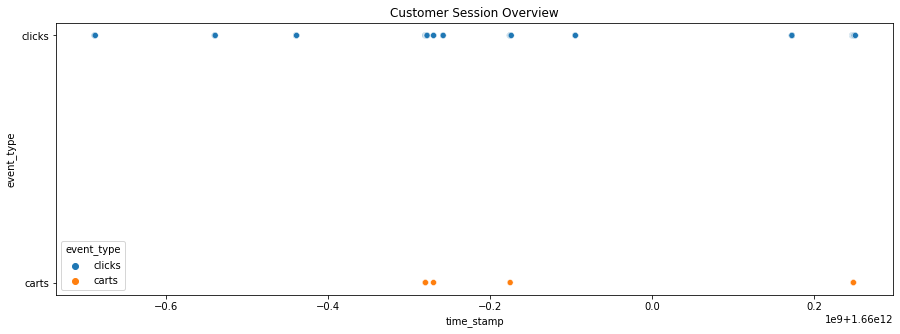

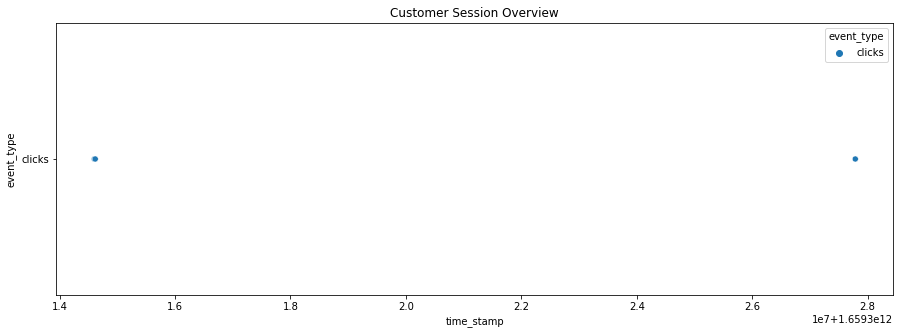

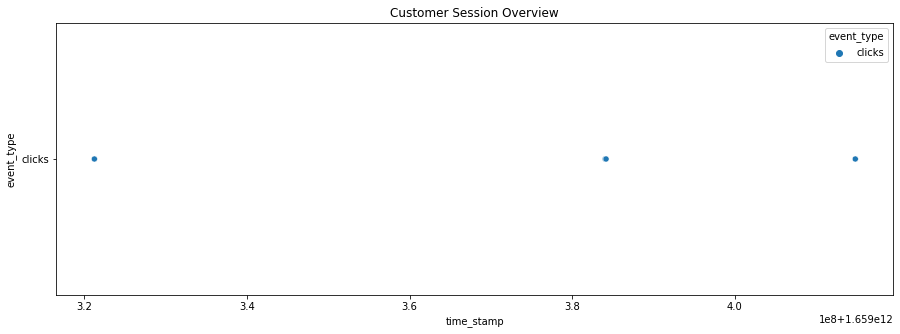

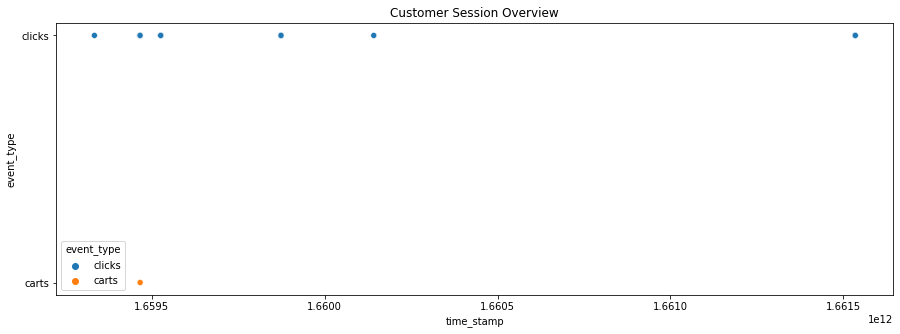

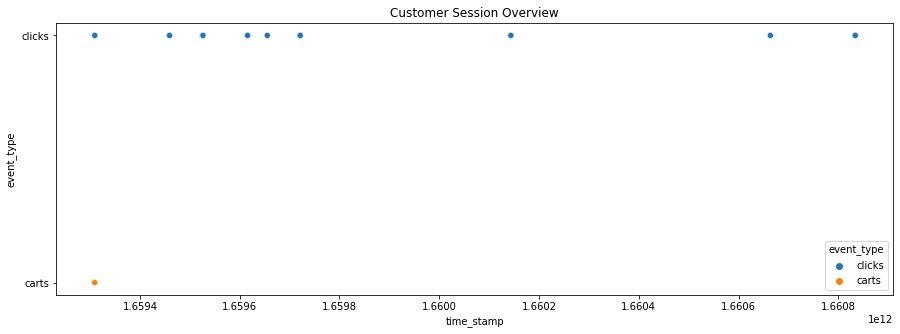

In [148]:
#  visualize customer session 
for customer in random.sample(range(200000), 5):
    customer_df = train[train['customer_id'] == customer]
    customer_df = customer_df.sort_values(by='time_stamp')
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title('Customer Session Overview')
    sns.scatterplot(x='time_stamp', y='event_type', data=customer_df, hue='event_type', ax=ax)
    plt.show()    

In [28]:
train.event_type.value_counts()

clicks    9320528
carts      751785
orders     213248
Name: event_type, dtype: int64

In [29]:
#  check orders after add to cart
train['order'] = train['event_type'].apply(lambda x: 1 if x=='orders' else 0)  # order dummy
train['add_to_cart'] = train['event_type'].apply(lambda x: 1 if x=='carts' else 0)  # add to cart dummy
train['order_after_cart'] = train['order'].shift(-1) + train['add_to_cart']
train['order_after_cart'] = train['order_after_cart'].apply(lambda x: 1 if x==2 else 0)
per = train['order_after_cart'].value_counts(normalize=True)[1]
print(f'percentage of orders after add to cart: {per:.2%}')


percentage of orders after add to cart: 0.63%


In [30]:
#  check add to carts after click
train['click'] = train['event_type'].apply(lambda x: 1 if x == 'clicks' else 0)
train['cart_after_click'] = train['click'].shift(-1) + train['add_to_cart']
train['cart_after_click'] = train['cart_after_click'].apply(lambda x: 1 if x==2 else 0)
per = train['cart_after_click'].value_counts(normalize=True)[1]
print(f'percentage of add to cart after clicks: {per:.2%}')

percentage of add to cart after clicks: 5.89%


In [31]:
#  check click after click
train['click_after_click'] = train['click'].shift(-1) + train['click']
train['click_after_click'] = train['click_after_click'].apply(lambda x: 1 if x==2 else 0)
per = train['click_after_click'].value_counts(normalize=True)[1]
print(f'percentage of add to cart after clicks: {per:.2%}')


percentage of add to cart after clicks: 83.64%


In [32]:
train.to_csv('../data/interim/add_rel_action.csv', index = False)
train

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/add_rel_action.csv'

/var/folders/t5/ydd18qxn5k56yh8rf4qh43gh0000gp/T/ipykernel_69962/1970588993.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=events_in_session.values, ax=ax, bins=30, kde=False)


Text(0.5, 0, 'Frequency')

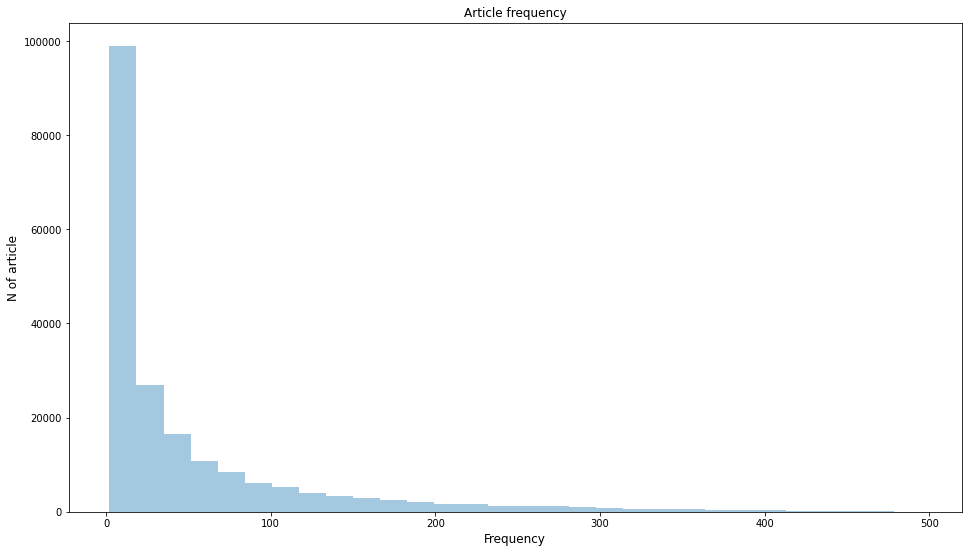

In [154]:
#  check frequency of articles
events_in_session = train.groupby(['customer_id'])['product_code'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=events_in_session.values, ax=ax, bins=30, kde=False)
ax.set_title('Article frequency', fontsize=12)
ax.set_ylabel('N of article', fontsize=12)
ax.set_xlabel('Frequency', fontsize=12)

/var/folders/s_/rl9604cd5r1026gskr5tdp580000gq/T/ipykernel_62069/2106163644.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=time_counts.values, ax=ax, bins=30, kde=False)


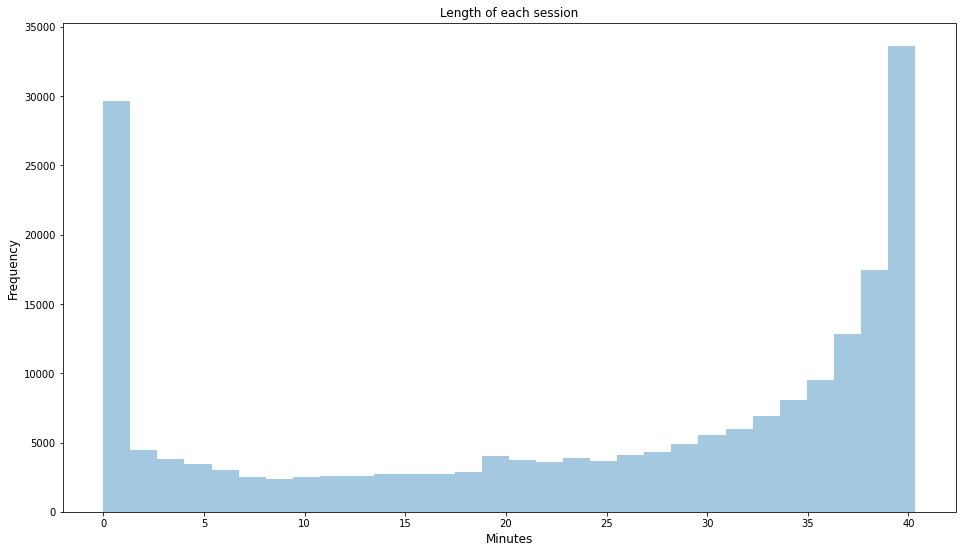

In [12]:
#  check how much time you spend in a day 
def count_seconds(x):
    max_value = int(x.max())
    min_value = int(x.min())
    session_time = datetime.timedelta(microseconds=max_value - min_value)
    return session_time.total_seconds() / 60 

time_counts = train.groupby(['customer_id'])['time_stamp'].apply(count_seconds)
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=time_counts.values, ax=ax, bins=30, kde=False)
ax.set_title('Length of each session', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Minutes', fontsize=12)
plt.show()

In [41]:
#  check orders after add to cart
def orders_add(df):
    df['order'] = df['event_type'].apply(lambda x: 1 if x=='orders' else 0)  # order dummy
    df['add_to_cart'] = df['event_type'].apply(lambda x: 1 if x=='carts' else 0)  # add to cart dummy
    df['order_after_cart'] = df['order'].shift(-1) + df['add_to_cart']
    df['order_after_cart'] = df['order_after_cart'].apply(lambda x: 1 if x==2 else 0)
    per = df['order_after_cart'].value_counts(normalize=True)[1]
    return(print(f'percentage of orders after add to cart: {per:.2%}'))
    #return(per)

#  check add to carts after click
def carts_click(df):
    df['click'] = df['event_type'].apply(lambda x: 1 if x == 'clicks' else 0)
    df['cart_after_click'] = df['click'].shift(-1) + df['add_to_cart']
    df['cart_after_click'] = df['cart_after_click'].apply(lambda x: 1 if x==2 else 0)
    per = df['cart_after_click'].value_counts(normalize=True)[1]
    #return(per)
    return(print(f'percentage of add to cart after clicks: {per:.2%}'))

#  check click after click
def click_click(df):
    df['click_after_click'] = df['click'].shift(-1) + df['click']
    df['click_after_click'] = df['click_after_click'].apply(lambda x: 1 if x==2 else 0)
    per = df['click_after_click'].value_counts(normalize=True)[1]
    return(print(f'percentage of add to cart after clicks: {per:.2%}'))
    #return(per)



    

- 50回以下，100回，以下の行動割合を出したい，購入割合など

# action回数が50回以下

In [37]:
event_types_in_session = train.groupby(['customer_id']).count()
event_types_in_session = event_types_in_session.query("product_code < 50")
event_types_in_session = event_types_in_session.reset_index()
event_types_in_session = event_types_in_session[["customer_id"]]
#print(event_types_in_session)


event_types_in_session_50 = pd.merge(event_types_in_session, train, on='customer_id', how='left')
orders_add(event_types_in_session_50)
carts_click(event_types_in_session_50)
click_click(event_types_in_session_50)




percentage of orders after add to cart: 0.67%
percentage of add to cart after clicks: 4.72%
percentage of add to cart after clicks: 86.66%


# action回数が50-100回

In [42]:
event_types_in_session = train.groupby(['customer_id']).count()
event_types_in_session = event_types_in_session.query("50<=product_code < 100")
event_types_in_session = event_types_in_session.reset_index()
event_types_in_session = event_types_in_session[["customer_id"]]
#print(event_types_in_session)

event_types_in_session_50_100 = pd.merge(event_types_in_session, train, on='customer_id', how='left')
orders_add(event_types_in_session_50_100)
carts_click(event_types_in_session_50_100)
click_click(event_types_in_session_50_100)


percentage of orders after add to cart: 0.73%
percentage of add to cart after clicks: 6.10%
percentage of add to cart after clicks: 82.76%


# action回数が100-200回

In [43]:
event_types_in_session = train.groupby(['customer_id']).count()
event_types_in_session = event_types_in_session.query("100<=product_code < 200")
event_types_in_session = event_types_in_session.reset_index()
event_types_in_session = event_types_in_session[["customer_id"]]
#print(event_types_in_session)

event_types_in_session_100_200 = pd.merge(event_types_in_session, train, on='customer_id', how='left')
orders_add(event_types_in_session_100_200)
carts_click(event_types_in_session_100_200)
click_click(event_types_in_session_100_200)

percentage of orders after add to cart: 0.67%
percentage of add to cart after clicks: 6.24%
percentage of add to cart after clicks: 82.54%


# action回数が200回以上

In [45]:
event_types_in_session = train.groupby(['customer_id']).count()
event_types_in_session = event_types_in_session.query("200<=product_code ")
event_types_in_session = event_types_in_session.reset_index()
event_types_in_session = event_types_in_session[["customer_id"]]
#print(event_types_in_session)

event_types_in_session_200 = pd.merge(event_types_in_session, train, on='customer_id', how='left')
orders_add(event_types_in_session_200)
carts_click(event_types_in_session_200)
click_click(event_types_in_session_200)

percentage of orders after add to cart: 0.54%
percentage of add to cart after clicks: 6.15%
percentage of add to cart after clicks: 83.28%


In [49]:
event_types_in_session = train.groupby(['customer_id']).count()
event_types_in_session = event_types_in_session.query("50<= product_code < 100")

event_types_in_session = event_types_in_session.reset_index()

event_types_in_session = event_types_in_session[["customer_id"]]
#print(event_types_in_session)


event_types_in_session_50_100 = pd.merge(event_types_in_session, train, on='customer_id', how='left')
print(event_types_in_session_50_100)




         customer_id  product_code  year_month  year  month  day  hour  \
0                 11       1110510      202207  2022      7    7    23   
1                 11       1110510      202208  2022      8    1    22   
2                 11       1178708      202208  2022      8    1    22   
3                 11       1343545      202208  2022      8    1    22   
4                 11       1343545      202208  2022      8    1    22   
...              ...           ...         ...   ...    ...  ...   ...   
1884488       199984       1007465      202208  2022      8    6     6   
1884489       199984       1275299      202208  2022      8    6     6   
1884490       199984       1007465      202208  2022      8    6     6   
1884491       199984         45646      202208  2022      8    6     7   
1884492       199984       1492657      202208  2022      8    6     7   

            time_stamp event_type          time_stamp_all  order  add_to_cart  \
0        1659304800172     cli

             product_code  year_month  year  month  day  hour  time_stamp  \
customer_id                                                                 
0                     276         276   276    276  276   276         276   
1                      32          32    32     32   32    32          32   
2                      33          33    33     33   33    33          33   
3                     226         226   226    226  226   226         226   
4                      19          19    19     19   19    19          19   
...                   ...         ...   ...    ...  ...   ...         ...   
199995                 17          17    17     17   17    17          17   
199996                 25          25    25     25   25    25          25   
199997                154         154   154    154  154   154         154   
199998                  2           2     2      2    2     2           2   
199999                  9           9     9      9    9     9           9   

/var/folders/s_/rl9604cd5r1026gskr5tdp580000gq/T/ipykernel_62069/2966239724.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)


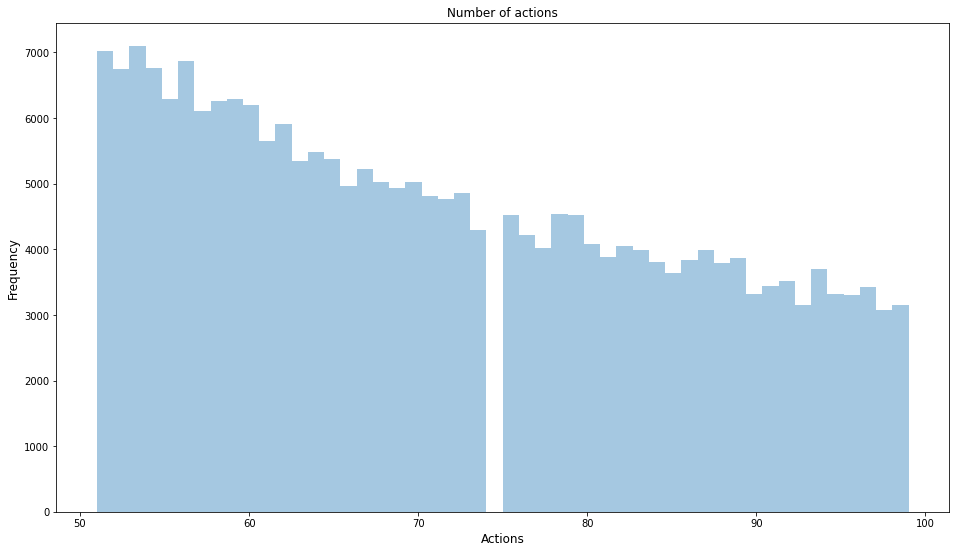

In [18]:
event_types_in_session = train.groupby(['customer_id']).count()
print(event_types_in_session)
event_types_in_session = event_types_in_session.query("50 < product_code < 100")
print(event_types_in_session)


#x = event_types_in_session
#print(x.values)

fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

/var/folders/t5/ydd18qxn5k56yh8rf4qh43gh0000gp/T/ipykernel_69962/3500998266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)


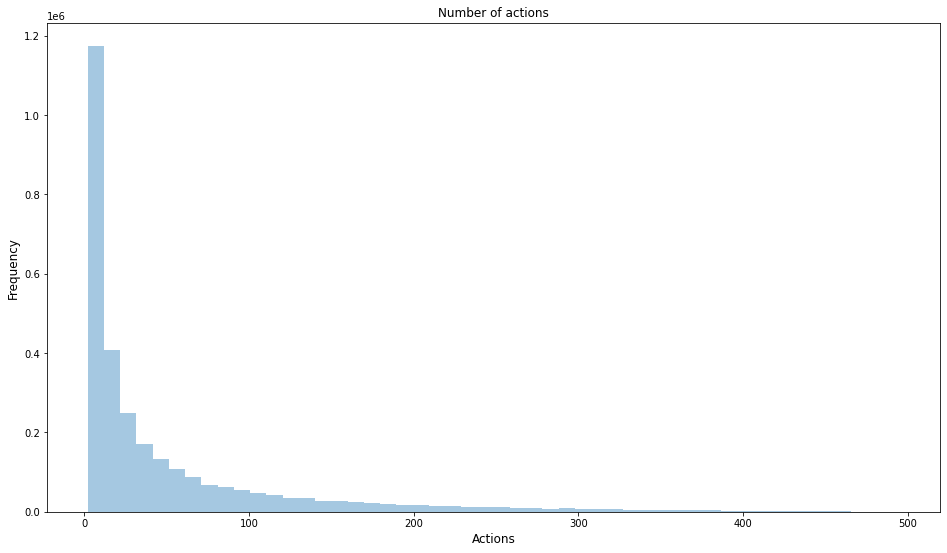

In [166]:
#  check frequency of actions(events)
event_types_in_session = train.groupby(['customer_id']).count()
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

/var/folders/t5/ydd18qxn5k56yh8rf4qh43gh0000gp/T/ipykernel_69962/3140739711.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)


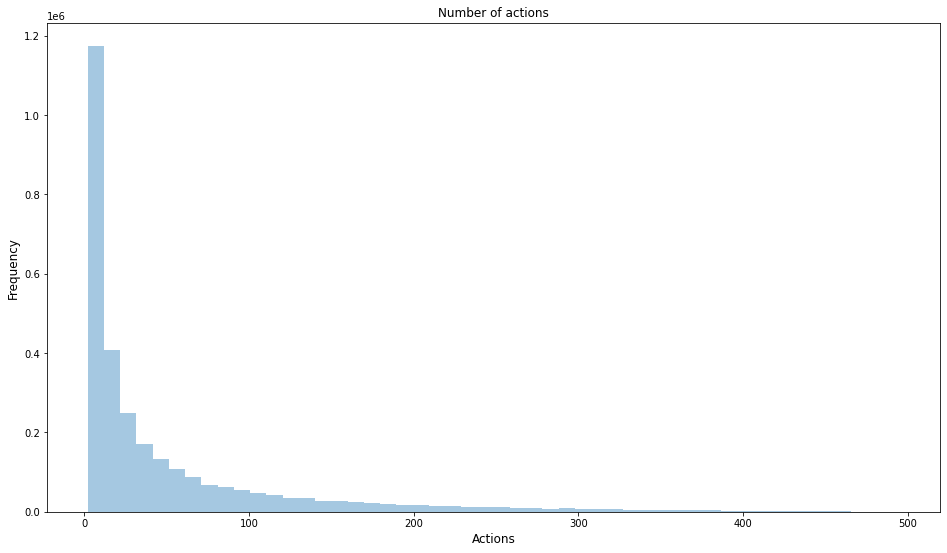

In [168]:
#  check number of events in a day
event_types_in_session = train.groupby(['customer_id']).count()
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

# 追加の分析
- 2変数での基礎集計
  - product_codeとの関係性を集計する
    - time_stampにどのproductがclicks/carts/ordersされているのか
    - 具体的にはmonth/day/hourのどのタイミングでproductがclicks/carts/ordersされたか
- 予測に関して
  - 正直，具体的な案が思いつかない．
  - 基礎集計の結果から頻度が多いものを予測結果とする？
    - 例えば，23hにはこのproductコードが選択されやすいから，テストデータにもその結果を反映させるなど